In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from multiprocess import Pool
from cfs_erf_spatial import erf_spatial
from pytorch_lightning import seed_everything

seed_everything(42);

/Users/sophie/opt/anaconda3/envs/space-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 42


### Load Environment

In [2]:
from spacebench import SpaceEnv, DataMaster
datamaster = DataMaster()
datasets = datamaster.master 
# find datasets that have continuous exposure
cts = datasets.index[datasets['exposure'] == 'continuous'].values
discrete = datasets.index[datasets['exposure'] == 'binary'].values


### Run spatial and spatial+ for each cts dataset environment, and dataset in parallel

Results are being saved in continuous.csv.

In [3]:
# for each environment
for envname in cts:
    env = SpaceEnv(str(envname))
    # for each masked variable
    dataset_list = list(env.make_all())
    args = list(zip(dataset_list, range(len(dataset_list))))
    with Pool(4) as p: # 4 is the number of processes
        pool_outputs = np.column_stack(
        (
        tqdm(
                p.imap(lambda m: erf_spatial(*m, envname = envname, filename = 'continuous.csv'), # does not preserve order of datasets
                            args),
                        # should write to continuous.csv a vector
                        total=len(dataset_list)
            )
        )
        )

  0%|          | 0/12 [00:00<?, ?it/s]/var/folders/vh/scv5k4_d0dsg0mt77xcvwv_m0000gn/T/ipykernel_51674/1667124433.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pool_outputs = np.column_stack(
  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/vh/scv5k4_d0dsg0mt77xcvwv_m0000gn/T/ipykernel_51674/1667124433.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pool_outputs = np.column_stack(
  0%|          | 0/34 [00:00<?, ?it/s]/var/folders/vh/scv5k4_d0dsg0mt77xcvwv_m0000gn/T/ipykernel_51674/1667124433.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators 

KeyboardInterrupt: 

### Analyze results by env: continuous

In [4]:
# function that will convert vector entries to vectors 
def convert_to_vector(entry):
    entry = entry.strip('[]').split()
    vector = np.array([float(element) for element in entry])
    return vector

(12, 18)


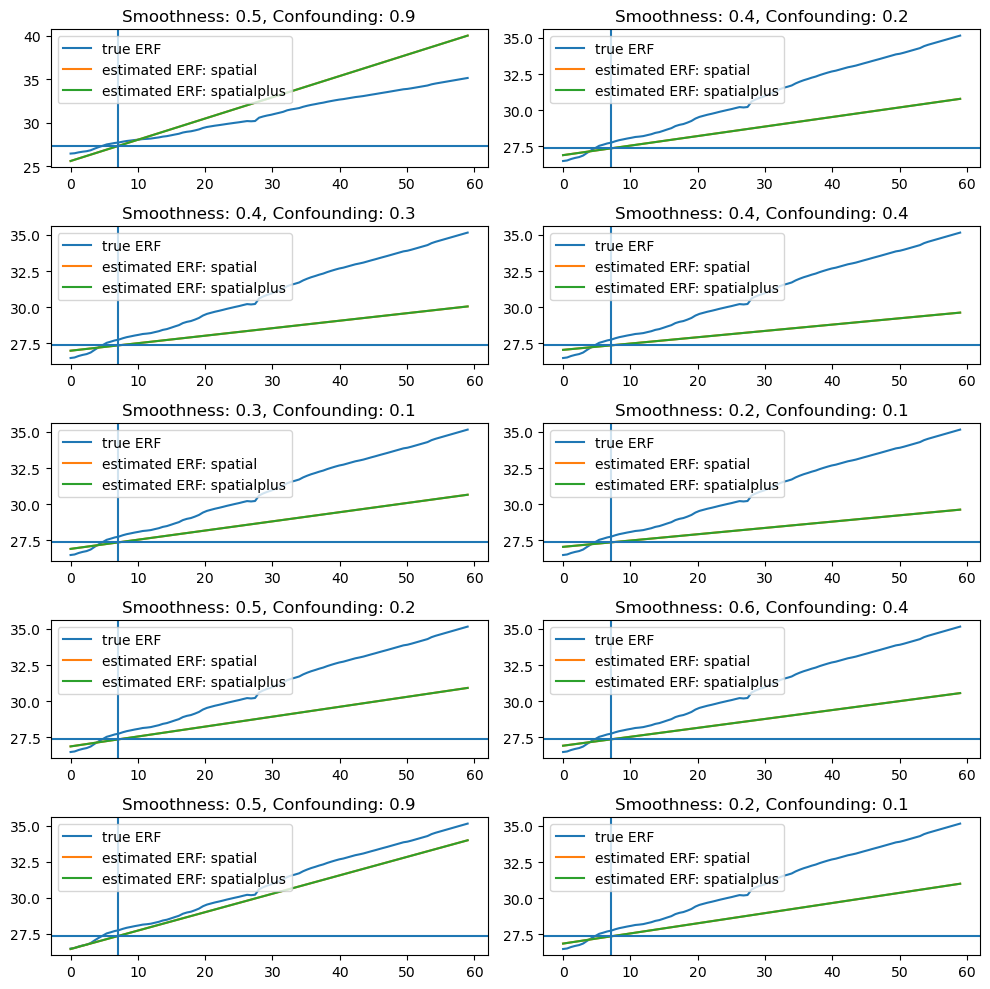

In [9]:
import matplotlib.pyplot as plt

outputs = pd.read_csv('continuous.csv', header = None)
outputs = outputs[outputs.iloc[:, 0] == cts[0]]
print(outputs.shape)
outputs.iloc[:,[4,5,6,7,8,9,12,13]] = outputs.iloc[:,[4,5,6,7,8,9,12,13]].apply(lambda x: x.apply(convert_to_vector))

# Exploratory analysis: plot ERF vs estimated ERF
fig, axes = plt.subplots(5, 2, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.plot(outputs.iloc[i, 4], outputs.iloc[i, 5], label='true ERF')
    ax.plot(outputs.iloc[i, 4], outputs.iloc[i, 6], label='estimated ERF: spatial')
    ax.plot(outputs.iloc[i, 4], outputs.iloc[i, 7], label='estimated ERF: spatialplus')
    ax.axvline(outputs.iloc[i, 16])
    ax.axhline(outputs.iloc[i, 17])
    ax.legend()
    ax.set_title('Smoothness: ' + str(round(outputs.iloc[i, 2],1)) + ', Confounding: ' + str(round(outputs.iloc[i, 3],1)))

plt.tight_layout()
plt.show()


In [6]:
outputs = pd.read_csv('continuous.csv', header = None)

for envname in cts:
    outputs = outputs[outputs.iloc[:, 0] == envname]

    smoothness_scores = outputs.iloc[:, 2]
    confounding_scores = outputs.iloc[:, 3] 
    erf_error_spatial = outputs.iloc[:, 10]
    erf_error_spatialplus = outputs.iloc[:, 11]
    pehe_spatial = outputs.iloc[:, 14]
    pehe_spatialplus = outputs.iloc[:, 15]

    erf_errors = dict(
        smoothness=["low" if x < 0.5 else "high" for x in smoothness_scores],
        confounding=["low" if x < 0.1 else "high" for x in confounding_scores],
        spatial_erf_avg_error=erf_error_spatial,
        spatialplus_erf_avg_error=erf_error_spatialplus,
        spatial_pehe_avg = pehe_spatial,
        spatialplus_pehe_avg = pehe_spatialplus
    )
    erf_errors = pd.DataFrame(erf_errors)
    display(erf_errors.groupby(["smoothness", "confounding"]).agg(["mean", "std"]))

spatial_erf_avg_error            \
                                        mean       std   
smoothness confounding                                   
high       high                     4.986489  2.942052   
low        high                     7.585207  1.848049   
           low                      5.771517       NaN   

                       spatialplus_erf_avg_error           spatial_pehe_avg  \
                                            mean       std             mean   
smoothness confounding                                                        
high       high                         4.986490  2.942053        11.591227   
low        high                         7.585067  1.846990        14.542865   
           low                          5.771518       NaN        12.537768   

                                 spatialplus_pehe_avg            
                             std                 mean       std  
smoothness confounding                                           
high       high         3.230856            11.591228  3.230856  
low        high         2.042610            14.542711  2.041439  
           low               NaN            12.537769       NaN

Empty DataFrame
Columns: [(spatial_erf_avg_error, mean), (spatial_erf_avg_error, std), (spatialplus_erf_avg_error, mean), (spatialplus_erf_avg_error, std), (spatial_pehe_avg, mean), (spatial_pehe_avg, std), (spatialplus_pehe_avg, mean), (spatialplus_pehe_avg, std)]
Index: []

Empty DataFrame
Columns: [(spatial_erf_avg_error, mean), (spatial_erf_avg_error, std), (spatialplus_erf_avg_error, mean), (spatialplus_erf_avg_error, std), (spatial_pehe_avg, mean), (spatial_pehe_avg, std), (spatialplus_pehe_avg, mean), (spatialplus_pehe_avg, std)]
Index: []

Empty DataFrame
Columns: [(spatial_erf_avg_error, mean), (spatial_erf_avg_error, std), (spatialplus_erf_avg_error, mean), (spatialplus_erf_avg_error, std), (spatial_pehe_avg, mean), (spatial_pehe_avg, std), (spatialplus_pehe_avg, mean), (spatialplus_pehe_avg, std)]
Index: []

Empty DataFrame
Columns: [(spatial_erf_avg_error, mean), (spatial_erf_avg_error, std), (spatialplus_erf_avg_error, mean), (spatialplus_erf_avg_error, std), (spatial_pehe_avg, mean), (spatial_pehe_avg, std), (spatialplus_pehe_avg, mean), (spatialplus_pehe_avg, std)]
Index: []

Empty DataFrame
Columns: [(spatial_erf_avg_error, mean), (spatial_erf_avg_error, std), (spatialplus_erf_avg_error, mean), (spatialplus_erf_avg_error, std), (spatial_pehe_avg, mean), (spatial_pehe_avg, std), (spatialplus_pehe_avg, mean), (spatialplus_pehe_avg, std)]
Index: []

Empty DataFrame
Columns: [(spatial_erf_avg_error, mean), (spatial_erf_avg_error, std), (spatialplus_erf_avg_error, mean), (spatialplus_erf_avg_error, std), (spatial_pehe_avg, mean), (spatial_pehe_avg, std), (spatialplus_pehe_avg, mean), (spatialplus_pehe_avg, std)]
Index: []